# Multilingual data sourcing

This notebook leverages the API python wrapper to build a series of API calls to plot and show monolingual and bilingual datasets using data from Europeana

- Bilingual means metadata fields in a specific that have an english translation
- Monlingual means metadata fields in a spefic language that do not have an english translation

This notebook leverages the SEARCH API and the Python Wrapper developed by the RnD team

You can find more details about the search and the record APIs in the following links:

*   https://pro.europeana.eu/page/search
*   https://pro.europeana.eu/page/record

Those APIs serve data using the Europeana Data Model: https://pro.europeana.eu/page/intro#edm


In [1]:
#Importing libraries
import  pyter
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pyeuropeana.apis as apis
import pyeuropeana.utils as utils
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 400)
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
from  datetime import date
import math
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 400)
pd.options.mode.chained_assignment = None

# General settings

In [2]:
#plottig styles
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.rc('legend', fontsize=15)
fontsize_ylabel=20
fontsize_xlabel=20
fontsize_title=30
plt.style.use('ggplot')
#image details
image_format = 'jpeg' # e.g .png, .svg, etc.
dpi=400
today=date.today()

 # Query  examples

In [3]:
#Example queryto extract Total results
response = apis.search  (
    query = '(proxy_dc_description.en:* NOT proxy_dc_description.it:*)', 
    rows = 5, 
    profile='r'
    )

Exception: 
    EUROPEANA_API_KEY not set. Set EUROPEANA_API_KEY as an environment variable running 'export EUROPEANA_API_KEY=yourapikey' in the terminal.
    If running in Google Colab use os.environ['EUROPEANA_API_KEY'] = 'yourapikey'
    

In [ ]:
#Check repeatibility number of items, tot_results, presence of duplicates
# Do not run if you do not need to run this check, as it costs time to run
df_=pd.DataFrame(columns=['n_rows','tot_results', 'n_items','n_dupls']) 
for n in range(10,1000,50):
    data = apis.search(query = '*:*',qf='(proxy_dc_description.no:* AND  proxy_dc_description.en:*)' ,rows =n)
    tot_result=data['totalResults']
    df_.loc[n,'tot_results']=tot_result
    df_.loc[n,'n_rows']=n
    df=utils.search2df(data).uri
    df_.loc[n,'n_items']=len(df)
    df_clean=df.drop_duplicates(keep='first', inplace=False)
    n_dupl=len(df)-len(df_clean)
    df_.loc[n,'n_dupls']=n_dupl
df_.reset_index(drop=True)

# Functions definition

The reference for the relevant multilingual fields is https://docs.google.com/spreadsheets/d/1wooy963C7RVHG8VavSqOnZGX4OUhD5H6ptPI1p4Lksg/edit#gid=0

In [ ]:

def language_queries(lang1,bilingual,lang2='en'):
    """ This function builds a set of queries to extract information  
    on monolingual or bilingual fields, where one of the fields is english 
    by default 
    lang1: string first language, use ISO code (ex: fr for french)
    bilingual: string possible values are "AND" or "NOT" to select monolingual or 
    bilingual queries respectively
    """
    queries={
        'dc_description': f'(proxy_dc_description.{lang1}:* {bilingual} proxy_dc_description.{lang2}:*)',
        'dc_title': f'(proxy_dc_title.{lang1}:* {bilingual} proxy_dc_title.{lang2}:*)',
        'dc_subject': f'(proxy_dc_subject.{lang1}:* {bilingual} proxy_dc_subject.{lang2}:*)',
        'dc_coverage': f'(proxy_dc_coverage.{lang1}:* {bilingual} proxy_dc_coverage.{lang2}:*)',
        'edm_current_location':f'(proxy_edm_currentLocation.{lang1}:* {bilingual} proxy_edm_currentLocation.{lang2}:*)',
        'dcterms_medium': f'(proxy_dcterms_medium.{lang1}:* {bilingual} proxy_dcterms_medium.{lang2}:*)',
        'dcterms_hasPart':f'(proxy_dcterms_hasPart.{lang1}:* {bilingual} proxy_dcterms_hasPart.{lang2}:*)',
        'dcterms_spatial':f'(proxy_dcterms_spatial.{lang1}:* {bilingual} proxy_dcterms_spatial.{lang2}:*)',
        'dc_format':f'(proxy_dc_format.{lang1}:* {bilingual} proxy_dc_format.{lang2}:*)',
        'dc_source':f'(proxy_dc_source.{lang1}:* {bilingual} proxy_dc_source.{lang2}:*)',
        'dc_rights':f'(proxy_dc_rights.{lang1}:* {bilingual} proxy_dc_rights.{lang2}:*)',
        'dc_terms_alternative':f'(proxy_dcterms_alternative.{lang1}:* {bilingual} proxy_dcterms_alternative.{lang2}:*)',
        'dc_type': f'(proxy_dc_type.{lang1}:* {bilingual} proxy_dc_type.{lang2}:*)',
        'dcterms_isPartOf': f'(proxy_dcterms_isPartOf.{lang1}:* {bilingual} proxy_dcterms_isPartOf.{lang2}:*)',
        'dcterms_provenance': f'(proxy_dcterms_provenance.{lang1}:* {bilingual} proxy_dcterms_provenance.{lang2}:*)',
        'dcterms_temporal': f'(proxy_dcterms_temporal.{lang1}:* {bilingual} proxy_dcterms_temporal.{lang2}:*)',
        'edm_isRelatedTo': f'(proxy_edm_isRelatedTo.{lang1}:* {bilingual} proxy_edm_isRelatedTo.{lang2}:*)',
        'edm_dataProvider': f'(provider_aggregation_edm_dataProvider.{lang1}:* {bilingual} provider_aggregation_edm_dataProvider.{lang2}:*)',
        'edm_intermediateProvider': f'(provider_aggregation_edm_intermediateProvider.{lang1}:* {bilingual} provider_aggregation_edm_intermediateProvider.{lang2}:*)',
        'edm_provider': f'(provider_aggregation_edm_provider.{lang1}:* {bilingual} provider_aggregation_edm_provider.{lang2}:*)',
        'dcterms_isReferencedBy': f'(wr_dcterms_isReferencedBy.{lang1}:* {bilingual} wr_dcterms_isReferencedBy.{lang2}:*)'
            }
    return queries

In [4]:
def multiple_language_queries(lang ,bilingual, lang2='en'):
    """This function builds a dictionary where each key is a 
    language and the values are all the queries from function language_queries 
    lang: lists of languages, ISO format
    bilingual: string possible values are "AND" or "NOT" to select monolingual or 
    bilingual queries
    """
    queries={}
    for l in lang:
        queries_single_l=language_queries(l,bilingual,lang2='en')
        queries[l]=queries_single_l
    return queries

In [5]:
def tot_results_queries(lang ,n_rows=1, save=False, biling=True):
    """This function returns a dataframe , 
    the first column indicates the metadata considered   
    the second column the number of hits for that specific field
    the index of the dataframe are the languages in the parameter lang
    lang:  languages, ISO format
    save: boolean, if TRUE the resulting dataframe is saved as csv file
    n_rows: parameter for the number of returned items
    """
    if biling:
        queries_dict=multiple_language_queries(lang ,bilingual='AND', lang2='en')
    else:
        queries_dict=multiple_language_queries(lang ,bilingual='NOT', lang2='en')
    df=pd.DataFrame(index=lang)
    for l in lang:
        for key, value in queries_dict[l].items():  
            CHO_data = apis.search(query = '*:*',qf=f'{value}' ,rows = n_rows)
            tot_results=CHO_data['totalResults']
            df.loc[l,key]=tot_results 
    df.loc[:,'Tot_results'] = df.iloc[:,:].sum(axis=1)
    if 'en' in df.index:
        df.drop('en', axis=0, inplace=True)
    df_percentage=pd.DataFrame(columns= df.columns, index=df.index)
    for col in df.columns:
        df_percentage[col]=df[col]/df.Tot_results
    df_percentage.drop('Tot_results',axis=1, inplace=True)
    df_percentage.loc[:,'Tot_results'] = df_percentage.iloc[:,:].sum(axis=1)
    if 'en' in df_percentage.index:
        df_percentage.drop('en', axis=0, inplace=True)
    tot_lang='_'.join(lang)
    if save and biling:
        df.to_csv(f'{today}_{tot_lang}_tot_results_bilingual.csv')
    elif save and not biling:
        df.to_csv(f'{today}_{tot_lang}_tot_results_monolingual.csv')
    return df, df_percentage


In [6]:
def queries_items_uri(lang, n_rows=1, save=False,biling=True):
    """This function build a dataframe where the first column indicates
    the type of query executed and the second the item that satisfies that query
    lang: string language in ISO format, takes one value of lang (not a list)
    save: boolean, if TRUE the resulting dataframe is saved as excel file
    n_rows: parameter for the number of returned items
    biling: boolean, if TRUE bilingual version of the queries is used, if FALSE the 
    monolingual version"""
    if biling:
        queries_dict=multiple_language_queries([lang] ,bilingual='AND', lang2='en')
    else:
        queries_dict=multiple_language_queries([lang] ,bilingual='NOT', lang2='en')
    # initalizing list of dataframes
    df_list=[]
    for _ ,value in queries_dict[lang].items():  
        print(value)
        df=pd.DataFrame(columns=['field','europeana_uri'])
        CHO_data = apis.search(query = '*:*',qf=f'{value}' ,rows = n_rows)
        n_files=CHO_data['totalResults']
        if n_files > 0:
            CHO_data_all = apis.search(query = '*:*',qf=f'{value}' ,rows = n_files)
            print('ok')
            df['europeana_uri']=utils.search2df(CHO_data_all).uri
            print(len(df))
            df['field']=value
            df_list.append(df)     
        else:
            pass 
    df_tot = pd.concat(df_list, ignore_index=True) # concatenate all dataframes from all queries
    df_tot_clear_dup=df_tot.drop_duplicates(subset=None, keep='first', inplace=False)
    if save and biling:
        df_tot_clear_dup.to_csv(f'{today}_{lang}_en_bilingual.csv')
    elif save and not biling:
        df_tot_clear_dup.to_csv(f'{today}_{lang}_monolingual.csv')
    return df_tot_clear_dup

In [7]:
def monoling_biling_to_stack(mono_nr, bili_nr, lang_list,save=True):
    """ This function generates a dataframe whose columns are 
    - the number of bilingual tags,
    - the number of monolingual tags
    - the number of total tags
    The index of the df are the languages contained in lang_list
    Three version of the dataframe are generated
    - df_sorted_biling: rows sorted per descendinng values of bilignual tags
    - df_sorted_monloling: rows sorted per descendinng values of monoling tags
    -df_sorted_tot_lang_tagged: rows sorted per descendinng values of total tags
      monlolingual and bilingual
      Parameters
      mono_nr: number of monlingual hits per language- series
      bilin_nr: number of monlingual hits per language- series
      lang_list: list of languages considered
    """
    df_tot=pd.DataFrame({'n_biling_tag':bili_nr.Tot_results,'n_monoling_tag':mono_nr.Tot_results}, index=lang_list)
    df_tot.loc[:,'Tot_lang_tag']=df_tot.loc[:,'n_biling_tag']+df_tot.loc[:,'n_monoling_tag']
    if 'en'in df_tot.index:
        df_sorted=df_tot.drop('en',axis=0)  
    else:
        df_sorted=df_tot
    df_sorted_biling=df_sorted.sort_values(by='n_biling_tag', ascending=False)
    df_sorted_monoling=df_sorted.sort_values(by='n_monoling_tag', ascending=False)
    df_sorted_tot_lang_tagged=df_sorted.sort_values(by='Tot_lang_tag', ascending=False)
    if save:
        file_name=f'{today}_mono_bilingual_tot_results.csv'
        df_sorted_biling.to_csv(file_name)
    return df_sorted_biling,df_sorted_monoling,df_sorted_tot_lang_tagged

# Plotting functions

In [7]:
def plot_tot_results(results_nr, results_pct, datatype='bilingual', save=True):
    """This function plots the monolingual or bilingual hits creating two subplts
    - The first is a barplot for the total language hits (monolingual or bilingual)
    - The second is a barplot with the results in percentages of the fields (monolingual or bilingual)
    Parameters
     results_nr: series- output of function tot_results_queries (absolute hits per fields)
     results_nr: series- output of function tot_results_queries(percentage numbers calculated on total hits)
     datatype: string used for labelling the plots- monlingual or bilingual
     """
    fig, axes = plt.subplots(2,1,figsize=(15, 10), sharex=True)
    axes[0].set_title(datatype,fontsize=fontsize_title)
    axes[0].set_ylabel(f'# {datatype} tagged metafields', fontsize=fontsize_ylabel )
    res_nr=results_nr['Tot_results'].sort_values(ascending=False)
    res_nr.plot(kind='bar', mark_right=True,ax=axes[0])
    axes[0].hlines(1e5, -1, 100,color='black',lw=3, label='100000 tagged fields')
    axes[0].legend(loc='upper right',fontsize=20)
    ########
    axes[1].set_ylabel('field percentage',fontsize= fontsize_ylabel)
    axes[1].set_ylim( ymax=1)
    results_pct_idx=results_pct.reindex(res_nr.index)
    results_pct_idx.iloc[:,:-1].plot(kind='bar', stacked=True, cmap="tab20c",ax=axes[1])
    box = axes[1].get_position()
    axes[1].set_position([box.x0, box.y0, box.width * 0.9, box.height])
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[1].set_ylim( ymax=1.1)
    fig.tight_layout()
    languages=list(results_nr.index.values) 
    tot_lang='_'.join(languages)
    if save:
        image_name=f'plot_{today}_{tot_lang}_{datatype}.{image_format}'
        fig.savefig(image_name, format=image_format, dpi=dpi)
    return None

In [8]:
def plot_stacked_bars_split(w,h,df,y_min_top,y_max_bottom, columns,save=True):
    """This function plots the monolingual and bilingual hits creating a stacked bar plot
    The plot contains also an interruption on the y axis to make the results more clear
    Parameters
    df: dataframe,  single df output of monoling_biling_to_stack fucntion
    w: width of plot
    h: height of plot
    y_min_top:   value for the top part of the split
    y_max_bottom:  value for the bottom part of the split
    columns: which columns in df to consider- typically 'n_biling_tag','n_monoling_tag' """
    fig,(ax,ax1) = plt.subplots(2,1,figsize=(w, h))
    fig.subplots_adjust(hspace=0.001)
    df[columns].plot(kind='bar', ax=ax1,stacked=True,legend=False)
    df[columns].plot(kind='bar', ax=ax,stacked=True)
    ax1.hlines(1e5, -1, 100,color='black',lw=3, label='100000 tagged fields')
    ax.hlines(1e5, -1, 100,color='black',lw=3, label='100000 tagged fields')
    ax.legend(loc='upper right')
    ax.set_xticks([]) 
    ax.set_title('number monolingual and bilingual (english-eu_language) metadata',fontsize=18)
    ax.legend(loc='upper right')
    ax.set_ylabel('# language tagged metadata fields',fontsize=16, loc='top')
    formatter = ticker.EngFormatter(unit='')
    Axis.set_major_formatter(ax.yaxis, formatter)
    Axis.set_major_formatter(ax1.yaxis, formatter)
    ax.set_ylim(ymin=y_min_top)
    ax1.set_ylim(ymax=y_max_bottom)
    ax.legend(loc='upper right')
    #ax.set_yticks([x for x in range(0,int(y_min_top), int(2e5))])
    ax1.set_yticks([x for x in range(0,int(y_max_bottom), int(2e5))])
    ax.set_yticks([x for x in range(int(y_min_top),int(12e6), int(3e6))])
    #plt.gca().yaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    fig.tight_layout()
    languages=list(df[columns].index.values) 
    tot_lang='_'.join(languages)
    if save:
        image_name=f'plot_{today}_{tot_lang}_mono_bili_stack.{image_format}'
        fig.savefig(image_name, format=image_format, dpi=dpi)
    return None

In [9]:
def plot_stacked_bars(w,h,df,y_min,y_max,y_step, columns, threshold=False, save=False):
    """This function plots the monolingual and bilingual hits creating a stacked bar plot
    Parameters
    df: dataframe,  single df output of monoling_biling_to_stack fucntion
    w: width of plot
    h: height of plot
    y_min: value for the min y shown
    y_max: value for the max y shown
    y_step: value for step of the y_tick
    columns: which columns in df to consider- typically 'n_biling_tag','n_monoling_tag' """
    fig, ax = plt.subplots(1,1,figsize=(w, h))
    df[columns].plot(kind='bar', ax=ax,stacked=True, legend=False)
    if threshold:
        ax.hlines(1e5, -1, 100,color='black',lw=3, label='100000 tagged fields')
    ax.legend(loc='upper right')
    ax.set_title('number monolingual and bilingual (english-eu_language) metadata',fontsize=18)
    ax.legend(loc='upper right')
    ax.set_ylabel('# language tagged metadata fields',fontsize=16, loc='top')
    formatter = ticker.EngFormatter(unit='')
    Axis.set_major_formatter(ax.yaxis, formatter)
    ax.set_ylim(ymax=y_max)
    ax.legend(loc='upper right')
    ax.set_yticks([x for x in range(int(y_min),int(y_max), int(y_step))])
    fig.tight_layout()
    languages=list(df[columns].index.values) 
    tot_lang='_'.join(languages)
    if save:
        image_name=f'plot_{today}_{tot_lang}_mono_bili_stack.{image_format}'
        fig.savefig(image_name, format=image_format, dpi=dpi)
    return None

Bulgarian Croatian Czech Danish Dutch English Estonian Finnish French German Greek Hungarian Irish Italian Latvian Lithuanian Maltese Polish Portuguese Romanian Slovak Slovene Spanish Swedish

## Building ensemble of languages to be used

In [10]:
#Official 24 languages
lg_iso_24={"bulgarian":"bg", "croatian":"hr", "czech":"cs","danish":"da", "dutch":"nl", "english":"en","estonian":"et",
 "finnish":"fi","french":"fr", "german":"de", "greek":"el","hungarian":"hu", "irish":"ga","italian":"it",
 "latvian":"lv","lithuanian":"lt","maltese":"mt","polish":"pl", "portoghese":"pt","romanian":"ro", 
 "slovak":"sk","slovenian":"sl", "spanish":"es", "swedish":"sv"}

In [11]:
# More general group of languages
lg_iso_eu={"bulgarian":"bg", "croatian":"hr", "czech":"cs","danish":"da", "dutch":"nl", "english":"en","estonian":"et",
 "finnish":"fi","french":"fr", "german":"de", "greek":"el","hungarian":"hu","italian":"it",
 "latvian":"lv","lithuanian":"lt","maltese":"mt","polish":"pl", "portoghese":"pt","romanian":"ro", 
 "slovak":"sk","slovenian":"sl", "spanish":"es", "swedish":"sv", "norvegian":"no","turkish":"tr", "catalan":"ca", "russian":"ru","bosniac":"bs"}

In [13]:
len(lg_iso_24)

24

In [14]:
lang_24=[]
for key, value in lg_iso_24.items():
    lang_24.append(value)

In [15]:
#all languages found so far, more than the 24 european
lang=['it', 'mul','fr','de','nl', 'en', 'hu'
     , 'sv', 'es', 'cs', 'el', 'ro'
     ,'ca','pl','pt', 'bg', 'da', 'no', 'hr',
     'lt', 'fi', 'et', 'ru', 'sr', 'lv', 'sl',
     'bs', 'sk', 'tr','hr','mt', 'rm','ga','ro', 'no']

In [16]:
#results for monolingual queries
monoling_res, monoling_res_pct=tot_results_queries(lang_24 ,n_rows=1, save=True, biling=False)
#results for bilingual queries
biling_res, biling_res_pct=tot_results_queries(lang_24,n_rows=1, save=True, biling=True)

# Plotting the statistics on metadata fields

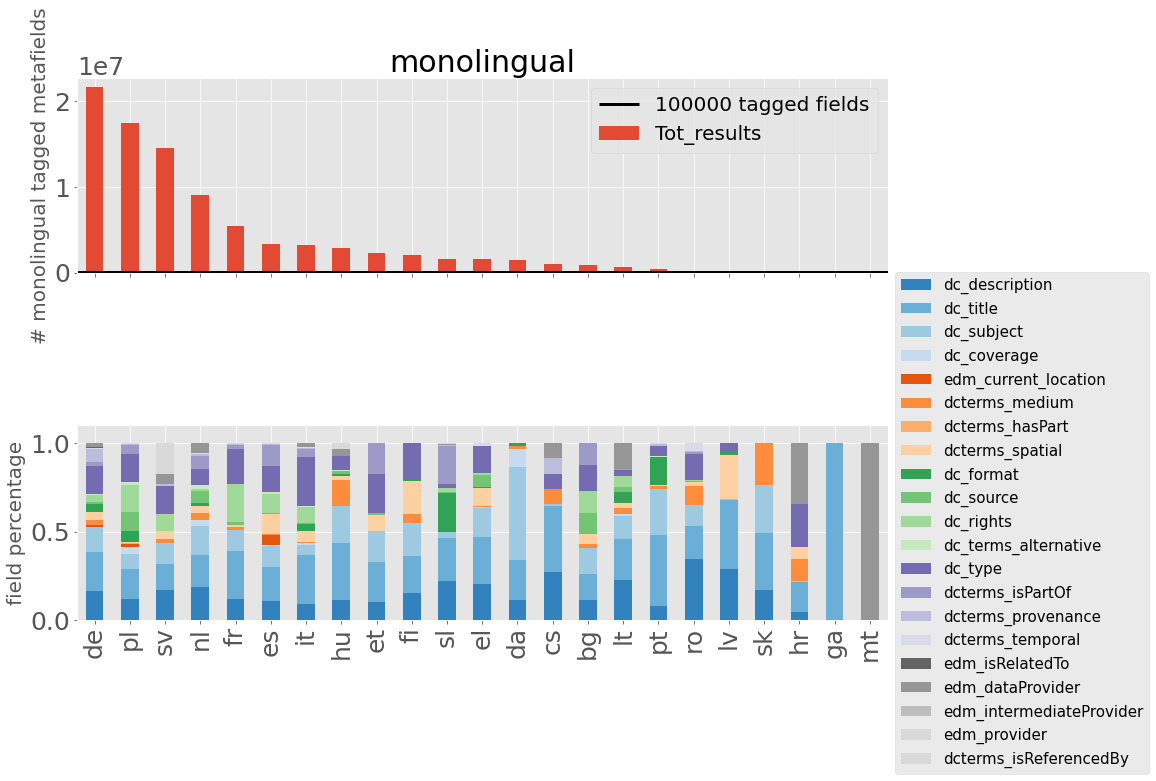

In [17]:
#total results bar chart plus bar chart stacked to show percentage of fields
# in the results
plot_tot_results(monoling_res, monoling_res_pct, datatype="monolingual")

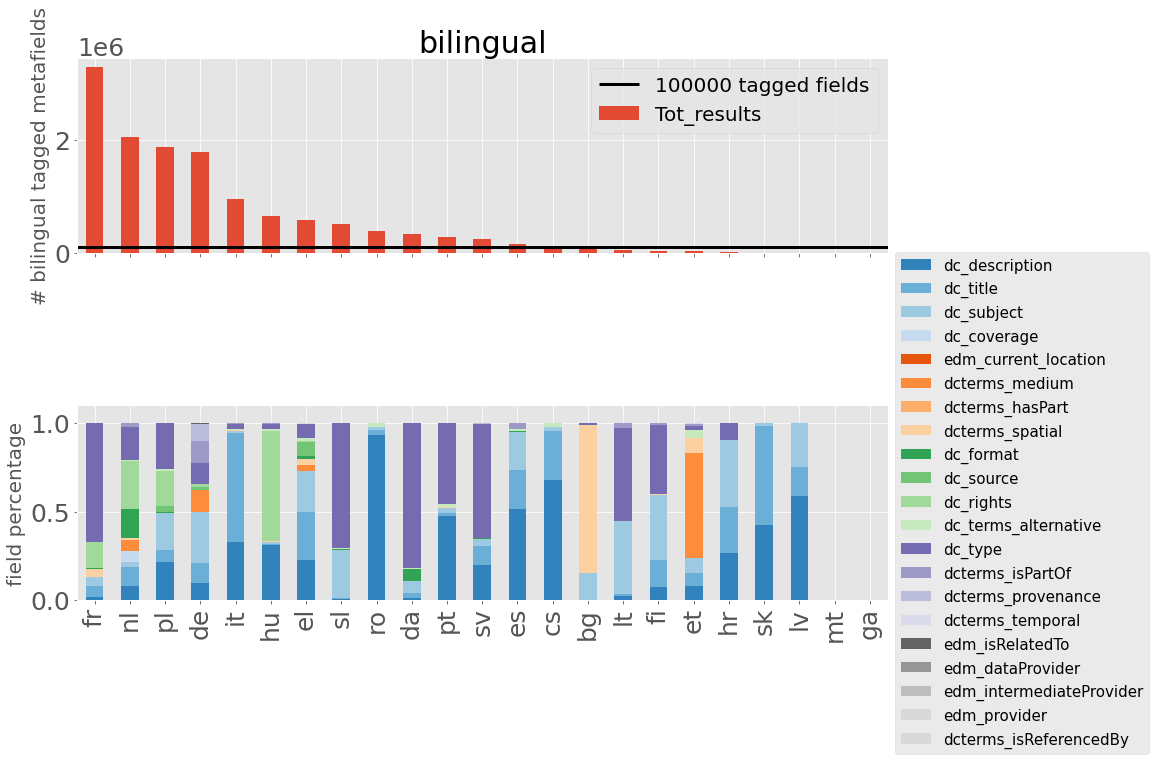

In [18]:
#total results for bilingual fields
plot_tot_results(biling_res, biling_res_pct, datatype="bilingual")

In [19]:
# producing intermediate dataframe for stacked bar plot
df_sorted_biling,_,_=monoling_biling_to_stack(monoling_res, biling_res, lang_list=lang_24)

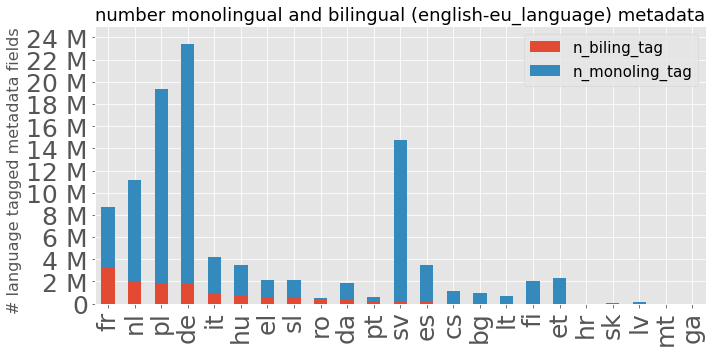

In [26]:
#plot barplotts bilingual-monolinguual with y-axes split for better visualization
plot_stacked_bars(10,5,df_sorted_biling,0 ,25e6,2e6,['n_biling_tag','n_monoling_tag'],save=True)

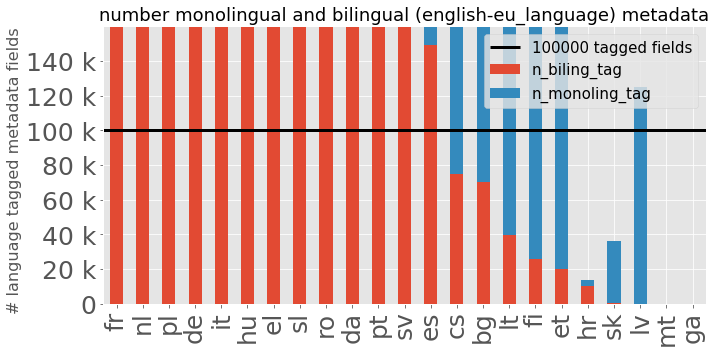

In [33]:
plot_stacked_bars(10,5,df_sorted_biling,0 ,0.16e6,2e4,['n_biling_tag','n_monoling_tag'], threshold=True, save=True)